# 08. Custom Datasets and Data Loading

Working with real-world data requires understanding how to create custom datasets and efficiently load data in PyTorch. This notebook will teach you everything you need to know about PyTorch's data loading system.

By the end of this notebook, you'll understand:

- How to create custom Dataset classes
- Efficient data loading with DataLoader
- Data preprocessing and transformations
- Handling different data types (images, text, tabular)
- Memory optimization and performance tips
- Advanced data loading patterns

**Why is this important?**

Most real-world ML projects require custom data loading because:

- Your data format might not match existing datasets
- You need specific preprocessing pipelines
- Performance optimization is crucial for large datasets
- Proper data handling prevents training bottlenecks


## The PyTorch Data Loading Pipeline

PyTorch's data loading system consists of several key components:

1. **Dataset**: Defines how to access individual data samples
2. **DataLoader**: Handles batching, shuffling, and parallel loading
3. **Transforms**: Apply preprocessing operations to data
4. **Sampler**: Controls how samples are drawn from the dataset

### Key Benefits:

- **Efficient**: Parallel data loading and preprocessing
- **Flexible**: Works with any data format
- **Memory-friendly**: Loads data on-demand
- **GPU-friendly**: Automatic data transfer to GPU


In [1]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
import time
from pathlib import Path
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

Using device: mps


## Creating Your First Custom Dataset

The `Dataset` class is the foundation of PyTorch's data loading system. Let's start with a simple example.


In [2]:
class SimpleDataset(Dataset):
    """
    A simple custom dataset for regression.
    Generates y = 2x + noise
    """

    def __init__(self, num_samples=1000, noise_std=0.1):
        self.num_samples = num_samples
        # Generate synthetic data
        self.x = torch.randn(num_samples, 1)
        self.y = 2 * self.x + torch.randn(num_samples, 1) * noise_std

    def __len__(self):
        """Return the total number of samples"""
        return self.num_samples

    def __getitem__(self, idx):
        """Return a single sample at index idx"""
        return self.x[idx], self.y[idx]


# Create and test the dataset
dataset = SimpleDataset(num_samples=100)
print(f"Dataset length: {len(dataset)}")

# Get a single sample
x_sample, y_sample = dataset[0]
print(f"Sample: x={x_sample.item():.3f}, y={y_sample.item():.3f}")

# Get multiple samples using slicing (if implemented)
for i in range(3):
    x, y = dataset[i]
    print(f"Sample {i}: x={x.item():.3f}, y={y.item():.3f}")

Dataset length: 100
Sample: x=1.927, y=3.926
Sample 0: x=1.927, y=3.926
Sample 1: x=1.487, y=2.984
Sample 2: x=0.901, y=1.763


## Using DataLoader for Efficient Batching

The `DataLoader` wraps a dataset and provides batching, shuffling, and parallel loading.


Number of batches: 7
Batch 0: x_shape=torch.Size([16, 1]), y_shape=torch.Size([16, 1])
Batch 1: x_shape=torch.Size([16, 1]), y_shape=torch.Size([16, 1])
Batch 2: x_shape=torch.Size([16, 1]), y_shape=torch.Size([16, 1])


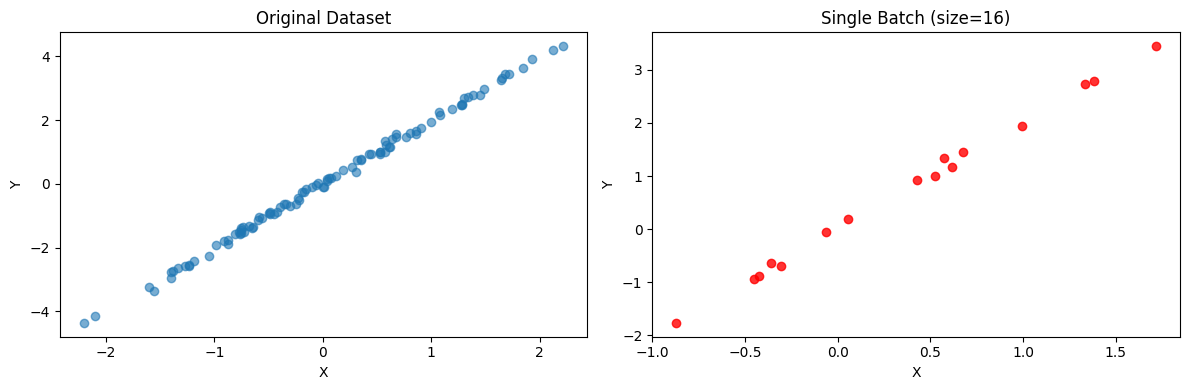

In [3]:
# Create a DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,  # Set to 0 for this example (no multiprocessing)
)

print(f"Number of batches: {len(dataloader)}")

# Iterate through batches
for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
    print(f"Batch {batch_idx}: x_shape={x_batch.shape}, y_shape={y_batch.shape}")
    if batch_idx >= 2:  # Only show first 3 batches
        break

# Visualize a batch
plt.figure(figsize=(12, 4))

# Plot 1: Original data
plt.subplot(1, 2, 1)
plt.scatter(dataset.x.numpy(), dataset.y.numpy(), alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Original Dataset")

# Plot 2: A single batch
x_batch, y_batch = next(iter(dataloader))
plt.subplot(1, 2, 2)
plt.scatter(x_batch.numpy(), y_batch.numpy(), alpha=0.8, color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Single Batch (size={len(x_batch)})")

plt.tight_layout()
plt.show()

## Working with Image Data

Let's create a more realistic example with image data. We'll create a custom dataset for loading images from a directory structure.


In [4]:
# First, let's create some dummy image data
def create_dummy_image_dataset(
    root_dir="dummy_images", num_classes=3, images_per_class=10
):
    """Create a dummy image dataset for demonstration"""
    root_path = Path(root_dir)

    # Create directory structure
    for class_idx in range(num_classes):
        class_dir = root_path / f"class_{class_idx}"
        class_dir.mkdir(parents=True, exist_ok=True)

        # Create dummy images
        for img_idx in range(images_per_class):
            # Create a random colored image
            img_array = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
            # Add some pattern based on class
            if class_idx == 0:  # Red-ish images
                img_array[:, :, 0] = np.clip(img_array[:, :, 0] + 100, 0, 255)
            elif class_idx == 1:  # Green-ish images
                img_array[:, :, 1] = np.clip(img_array[:, :, 1] + 100, 0, 255)
            else:  # Blue-ish images
                img_array[:, :, 2] = np.clip(img_array[:, :, 2] + 100, 0, 255)

            img = Image.fromarray(img_array)
            img.save(class_dir / f"image_{img_idx:03d}.png")

    print(f"Created dummy dataset in {root_dir}/")
    return root_path


# Create dummy data
dataset_path = create_dummy_image_dataset()

Created dummy dataset in dummy_images/


In [5]:
class ImageDataset(Dataset):
    """
    Custom dataset for loading images from a directory structure.
    Expected structure:
    root_dir/
        class_0/
            image1.jpg
            image2.jpg
        class_1/
            image1.jpg
            image2.jpg
    """

    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []
        self.class_names = []

        # Iterate through class directories
        for class_idx, class_dir in enumerate(sorted(self.root_dir.iterdir())):
            if class_dir.is_dir():
                self.class_names.append(class_dir.name)

                # Collect all images in this class
                for img_path in class_dir.glob("*.png"):
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)

        print(
            f"Found {len(self.image_paths)} images across {len(self.class_names)} classes"
        )
        print(f"Classes: {self.class_names}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        return image, label


# Create transforms
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),  # Normalize to [-1, 1]
    ]
)

# Create dataset and dataloader
image_dataset = ImageDataset(dataset_path, transform=transform)
image_dataloader = DataLoader(image_dataset, batch_size=8, shuffle=True)

# Test the dataset
sample_images, sample_labels = next(iter(image_dataloader))
print(f"Batch shape: {sample_images.shape}")
print(f"Labels: {sample_labels}")

Found 30 images across 3 classes
Classes: ['class_0', 'class_1', 'class_2']
Batch shape: torch.Size([8, 3, 32, 32])
Labels: tensor([2, 0, 1, 1, 1, 2, 0, 0])


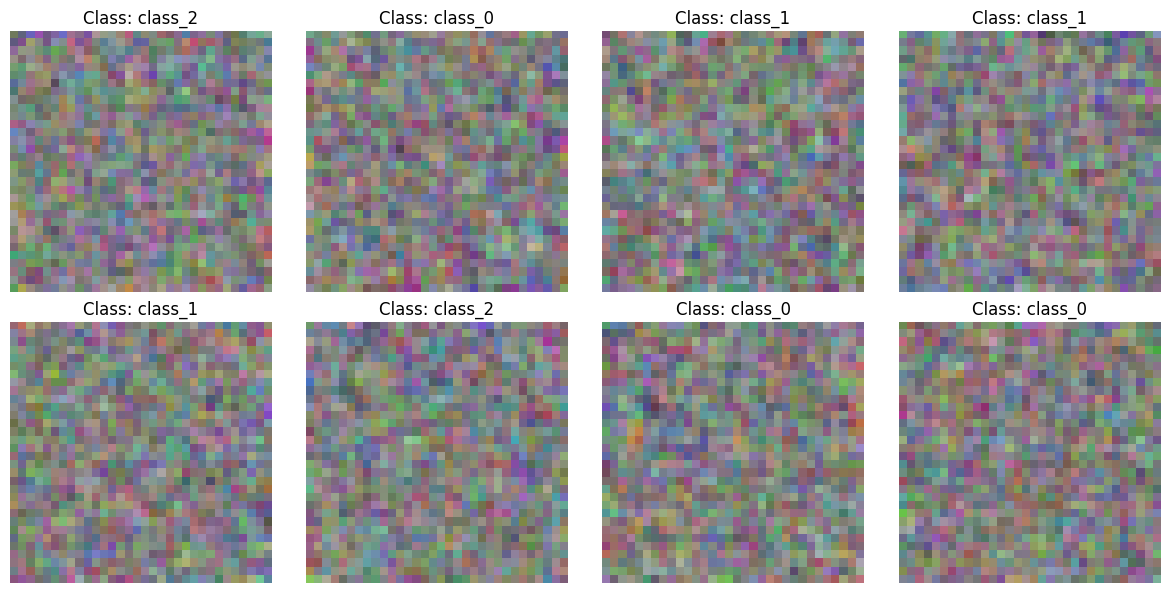

In [6]:
# Visualize the loaded images
def show_batch(images, labels, class_names):
    """Display a batch of images"""
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(min(8, len(images))):
        # Convert from tensor to displayable format
        img = images[i].permute(1, 2, 0)  # CHW -> HWC
        img = img * 0.5 + 0.5  # Denormalize from [-1,1] to [0,1]
        img = torch.clamp(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[labels[i]]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


show_batch(sample_images, sample_labels, image_dataset.class_names)

## Working with CSV/Tabular Data

Many real-world datasets come in CSV format. Let's create a custom dataset for tabular data.


In [7]:
# Create a dummy CSV dataset
def create_dummy_csv_dataset(filename="dummy_data.csv", num_samples=1000):
    """Create a dummy CSV dataset for demonstration"""
    np.random.seed(42)

    # Generate synthetic tabular data
    data = {
        "feature_1": np.random.randn(num_samples),
        "feature_2": np.random.randn(num_samples),
        "feature_3": np.random.randint(0, 5, num_samples),  # Categorical
        "feature_4": np.random.uniform(0, 100, num_samples),
    }

    # Create target based on features (classification)
    target = (
        data["feature_1"] + data["feature_2"] + data["feature_4"] / 50 > 0.5
    ).astype(int)
    data["target"] = target

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Created CSV dataset: {filename}")
    return df


# Create dummy CSV data
csv_data = create_dummy_csv_dataset()
print(csv_data.head())

Created CSV dataset: dummy_data.csv
   feature_1  feature_2  feature_3  feature_4  target
0   0.496714   1.399355          2  75.850188       1
1  -0.138264   0.924634          2   1.462826       1
2   0.647689   0.059630          2  20.724230       1
3   1.523030  -0.646937          3  71.323587       1
4  -0.234153   0.698223          4  38.662017       1


In [8]:
class CSVDataset(Dataset):
    """
    Custom dataset for loading tabular data from CSV files.
    """

    def __init__(self, csv_file, target_column, feature_columns=None, transform=None):
        self.data = pd.read_csv(csv_file)
        self.target_column = target_column
        self.transform = transform

        # Select feature columns
        if feature_columns is None:
            self.feature_columns = [
                col for col in self.data.columns if col != target_column
            ]
        else:
            self.feature_columns = feature_columns

        # Extract features and targets
        self.features = self.data[self.feature_columns].values.astype(np.float32)
        self.targets = self.data[target_column].values.astype(np.float32)

        print(
            f"Dataset loaded: {len(self)} samples, {len(self.feature_columns)} features"
        )
        print(f"Feature columns: {self.feature_columns}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.from_numpy(self.features[idx])
        target = torch.tensor(self.targets[idx])

        if self.transform:
            features = self.transform(features)

        return features, target


# Create dataset and dataloader
csv_dataset = CSVDataset("dummy_data.csv", target_column="target")
csv_dataloader = DataLoader(csv_dataset, batch_size=32, shuffle=True)

# Test the dataset
features_batch, targets_batch = next(iter(csv_dataloader))
print(f"Features shape: {features_batch.shape}")
print(f"Targets shape: {targets_batch.shape}")
print(f"Sample features: {features_batch[0]}")
print(f"Sample target: {targets_batch[0]}")

Dataset loaded: 1000 samples, 4 features
Feature columns: ['feature_1', 'feature_2', 'feature_3', 'feature_4']
Features shape: torch.Size([32, 4])
Targets shape: torch.Size([32])
Sample features: tensor([-0.0627,  0.3088,  1.0000, 52.3143])
Sample target: 1.0


## Data Transformations

Transforms are a powerful way to preprocess data. Let's explore different types of transforms.


Found 30 images across 3 classes
Classes: ['class_0', 'class_1', 'class_2']
Found 30 images across 3 classes
Classes: ['class_0', 'class_1', 'class_2']


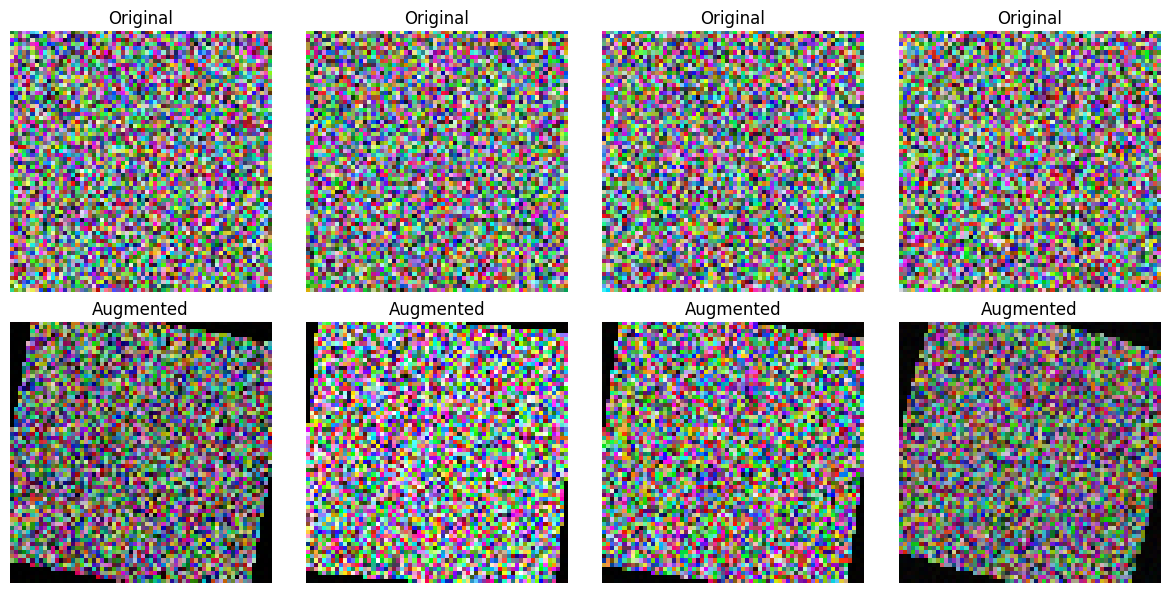

In [9]:
from torchvision import transforms


# Define various transforms for images
class AddNoise:
    """Custom transform to add noise to images"""

    def __init__(self, noise_std=0.1):
        self.noise_std = noise_std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.noise_std
        return tensor + noise


# Common image transforms
basic_transforms = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ]
)

augmentation_transforms = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # ImageNet stats
        AddNoise(noise_std=0.05),
    ]
)

# Create datasets with different transforms
basic_dataset = ImageDataset(dataset_path, transform=basic_transforms)
augmented_dataset = ImageDataset(dataset_path, transform=augmentation_transforms)


# Compare original and augmented images
def compare_transforms():
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    # Original images
    basic_loader = DataLoader(basic_dataset, batch_size=4, shuffle=True)
    aug_loader = DataLoader(augmented_dataset, batch_size=4, shuffle=True)

    basic_batch, _ = next(iter(basic_loader))
    aug_batch, _ = next(iter(aug_loader))

    for i in range(4):
        # Original
        img_basic = basic_batch[i].permute(1, 2, 0)
        axes[0, i].imshow(img_basic)
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Augmented
        img_aug = aug_batch[i].permute(1, 2, 0)
        img_aug = img_aug * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor(
            [0.485, 0.456, 0.406]
        )  # Denormalize
        img_aug = torch.clamp(img_aug, 0, 1)
        axes[1, i].imshow(img_aug)
        axes[1, i].set_title("Augmented")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


compare_transforms()

## Advanced Dataset Patterns

### 1. Dataset with Caching

For datasets where loading is expensive, you might want to cache data in memory.


In [10]:
class CachedDataset(Dataset):
    """
    Dataset that caches data in memory after first access.
    Useful for datasets where loading is expensive.
    """

    def __init__(self, base_dataset, cache_size=None):
        self.base_dataset = base_dataset
        self.cache = {}
        self.cache_size = cache_size or len(base_dataset)
        self.access_count = {}

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Return from cache if available
        if idx in self.cache:
            self.access_count[idx] = self.access_count.get(idx, 0) + 1
            return self.cache[idx]

        # Load from base dataset
        data = self.base_dataset[idx]

        # Cache if there's space
        if len(self.cache) < self.cache_size:
            self.cache[idx] = data
            self.access_count[idx] = 1

        return data


# Test caching performance
def test_caching_performance():
    # Create datasets
    regular_dataset = ImageDataset(dataset_path, transform=basic_transforms)
    cached_dataset = CachedDataset(regular_dataset, cache_size=20)

    # Time regular access
    start_time = time.time()
    for i in range(20):
        _ = regular_dataset[i % len(regular_dataset)]
    regular_time = time.time() - start_time

    # Time cached access (first time - cold cache)
    start_time = time.time()
    for i in range(20):
        _ = cached_dataset[i % len(cached_dataset)]
    cached_cold_time = time.time() - start_time

    # Time cached access (second time - warm cache)
    start_time = time.time()
    for i in range(20):
        _ = cached_dataset[i % len(cached_dataset)]
    cached_warm_time = time.time() - start_time

    print(f"Regular dataset: {regular_time:.4f}s")
    print(f"Cached dataset (cold): {cached_cold_time:.4f}s")
    print(f"Cached dataset (warm): {cached_warm_time:.4f}s")
    print(f"Speedup: {regular_time / cached_warm_time:.2f}x")


test_caching_performance()

Found 30 images across 3 classes
Classes: ['class_0', 'class_1', 'class_2']
Regular dataset: 0.0067s
Cached dataset (cold): 0.0054s
Cached dataset (warm): 0.0000s
Speedup: 554.04x


### 2. Dataset Concatenation and Subset

PyTorch provides utilities to combine and subset datasets.


In [11]:
from torch.utils.data import ConcatDataset, Subset, random_split

# Create multiple datasets
dataset1 = SimpleDataset(num_samples=100, noise_std=0.1)
dataset2 = SimpleDataset(num_samples=100, noise_std=0.2)
dataset3 = SimpleDataset(num_samples=100, noise_std=0.3)

# Concatenate datasets
combined_dataset = ConcatDataset([dataset1, dataset2, dataset3])
print(f"Combined dataset length: {len(combined_dataset)}")

# Create a subset
subset_indices = list(range(0, 150, 2))  # Every other sample from first 150
subset_dataset = Subset(combined_dataset, subset_indices)
print(f"Subset dataset length: {len(subset_dataset)}")

# Random split for train/validation
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Combined dataset length: 300
Subset dataset length: 75
Train dataset length: 240
Validation dataset length: 60


### 3. Custom Sampler

Sometimes you need custom sampling strategies.


In [12]:
from torch.utils.data import Sampler


class BalancedSampler(Sampler):
    """
    Sampler that ensures balanced sampling across classes.
    """

    def __init__(self, dataset, num_samples=None):
        self.dataset = dataset
        self.num_samples = num_samples or len(dataset)

        # Group indices by class
        self.class_indices = {}
        for idx, (_, label) in enumerate(dataset):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)

        self.num_classes = len(self.class_indices)
        print(f"Found {self.num_classes} classes")
        for class_label, indices in self.class_indices.items():
            print(f"Class {class_label}: {len(indices)} samples")

    def __iter__(self):
        # Generate balanced samples
        samples = []
        samples_per_class = self.num_samples // self.num_classes

        for class_label, indices in self.class_indices.items():
            # Sample with replacement if needed
            class_samples = torch.multinomial(
                torch.ones(len(indices)), samples_per_class, replacement=True
            ).tolist()
            samples.extend([indices[i] for i in class_samples])

        # Shuffle the final samples
        random.shuffle(samples)
        return iter(samples)

    def __len__(self):
        return self.num_samples


# Test balanced sampling
balanced_sampler = BalancedSampler(image_dataset, num_samples=24)
balanced_loader = DataLoader(image_dataset, batch_size=8, sampler=balanced_sampler)

# Check class distribution in batches
class_counts = torch.zeros(len(image_dataset.class_names))
for images, labels in balanced_loader:
    for label in labels:
        class_counts[label] += 1

print("Class distribution with balanced sampler:")
for i, count in enumerate(class_counts):
    print(f"Class {image_dataset.class_names[i]}: {count.item()} samples")

Found 3 classes
Class 0: 10 samples
Class 1: 10 samples
Class 2: 10 samples
Class distribution with balanced sampler:
Class class_0: 8.0 samples
Class class_1: 8.0 samples
Class class_2: 8.0 samples


## Real-World Example: Complete Data Pipeline

Let's put everything together in a comprehensive example that demonstrates a complete data pipeline.


In [15]:
class AdvancedImageDataset(Dataset):
    """
    Advanced image dataset with comprehensive features:
    - Multiple data sources
    - Data augmentation
    - Caching
    - Error handling
    """

    def __init__(
        self, root_dirs, transform=None, cache_size=100, load_into_memory=False
    ):
        self.transform = transform
        self.cache = {}
        self.cache_size = cache_size
        self.load_into_memory = load_into_memory

        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []
        self.class_names = []

        # Handle multiple root directories
        if isinstance(root_dirs, (str, Path)):
            root_dirs = [root_dirs]

        class_idx = 0
        for root_dir in root_dirs:
            root_path = Path(root_dir)
            for class_dir in sorted(root_path.iterdir()):
                if class_dir.is_dir():
                    if class_dir.name not in self.class_names:
                        self.class_names.append(class_dir.name)
                        current_class_idx = len(self.class_names) - 1
                    else:
                        current_class_idx = self.class_names.index(class_dir.name)

                    for img_path in class_dir.glob("*.png"):
                        self.image_paths.append(img_path)
                        self.labels.append(current_class_idx)

        # Load all data into memory if requested
        self.memory_data = {}
        if self.load_into_memory:
            print("Loading all data into memory...")
            for idx in range(len(self.image_paths)):
                self.memory_data[idx] = self._load_sample(idx)

        print(
            f"Dataset initialized: {len(self)} samples, {len(self.class_names)} classes"
        )

    def _load_sample(self, idx):
        """Load a single sample from disk"""
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")
            label = self.labels[idx]
            return image, label
        except Exception as e:
            print(f"Error loading {self.image_paths[idx]}: {e}")
            # Return a default image/label in case of error
            return Image.new("RGB", (64, 64), color=(128, 128, 128)), 0

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Return from memory if loaded
        if self.load_into_memory:
            image, label = self.memory_data[idx]
        # Return from cache if available
        elif idx in self.cache:
            image, label = self.cache[idx]
        else:
            # Load from disk
            image, label = self._load_sample(idx)

            # Cache if there's space
            if len(self.cache) < self.cache_size:
                self.cache[idx] = (image, label)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label


# Create comprehensive transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Create datasets
train_dataset = AdvancedImageDataset(
    dataset_path, transform=train_transforms, cache_size=50, load_into_memory=False
)

val_dataset = AdvancedImageDataset(
    dataset_path,
    transform=val_transforms,
    cache_size=50,
    load_into_memory=True,  # Smaller dataset, load into memory
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
    drop_last=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)

print(f"Train loader: {len(train_loader)} batches")
print(f"Validation loader: {len(val_loader)} batches")

Dataset initialized: 30 samples, 3 classes
Loading all data into memory...
Dataset initialized: 30 samples, 3 classes
Train loader: 1 batches
Validation loader: 2 batches


## Best Practices and Tips

### 1. Memory Management

- Use `pin_memory=True` when transferring to GPU
- Consider loading small datasets into memory
- Use caching for expensive preprocessing
- Monitor memory usage with large datasets

### 2. Performance Optimization

- Experiment with `num_workers` (usually 2-4 times number of CPU cores)
- Use `drop_last=True` for training to ensure consistent batch sizes
- Prefetch data using `persistent_workers=True` for large datasets

### 3. Data Handling

- Always handle loading errors gracefully
- Validate data integrity during dataset creation
- Use appropriate transforms for train/validation splits
- Normalize data consistently

### 4. Debugging

- Start with small datasets and `num_workers=0`
- Print dataset statistics (mean, std, class distribution)
- Visualize samples to verify correct loading
- Use `torch.utils.data.get_worker_info()` for debugging multiprocessing


In [ ]:
# Example debugging function
def debug_dataset(dataset, dataloader, num_samples=5):
    """Debug function to inspect dataset and dataloader"""
    print("=== Dataset Debug Info ===")
    print(f"Dataset length: {len(dataset)}")

    if hasattr(dataset, "class_names"):
        print(f"Classes: {dataset.class_names}")

    # Sample statistics
    print("\n=== Sample Statistics ===")
    sample_data = []
    sample_labels = []

    for i in range(min(num_samples, len(dataset))):
        data, label = dataset[i]
        if isinstance(data, torch.Tensor):
            sample_data.append(data)
        sample_labels.append(label)

    if sample_data:
        sample_tensor = torch.stack(sample_data)
        print(f"Data shape: {sample_tensor.shape}")
        print(f"Data range: [{sample_tensor.min():.3f}, {sample_tensor.max():.3f}]")
        print(f"Data mean: {sample_tensor.mean():.3f}")
        print(f"Data std: {sample_tensor.std():.3f}")

    print(f"Labels: {sample_labels}")

    # DataLoader statistics
    print("\n=== DataLoader Debug Info ===")
    print(f"Number of batches: {len(dataloader)}")
    print(f"Batch size: {dataloader.batch_size}")
    print(f"Shuffle: {dataloader.shuffle}")
    print(f"Num workers: {dataloader.num_workers}")

    # Time one batch
    start_time = time.time()
    batch_data, batch_labels = next(iter(dataloader))
    load_time = time.time() - start_time

    print(f"Batch loading time: {load_time:.3f}s")
    print(f"Batch data shape: {batch_data.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")


# Debug our dataset
debug_dataset(train_dataset, train_loader)

## Summary

In this notebook, we've covered the complete PyTorch data loading system:

### Key Components Learned:

1. **Custom Dataset Classes**: How to create datasets for any data type
2. **DataLoader**: Efficient batching, shuffling, and parallel loading
3. **Transforms**: Data preprocessing and augmentation
4. **Advanced Patterns**: Caching, concatenation, sampling strategies
5. **Performance Optimization**: Memory management and GPU transfer
6. **Best Practices**: Debugging, error handling, and real-world considerations

### When to Use What:

- **Simple datasets**: Use basic Dataset + DataLoader
- **Image data**: Use transforms for preprocessing and augmentation
- **Large datasets**: Consider caching, multiprocessing, and memory optimization
- **Imbalanced data**: Use custom samplers for balanced training
- **Multiple data sources**: Use ConcatDataset or custom logic

### Next Steps:

- Practice creating datasets for your specific data types
- Experiment with different transform combinations
- Profile your data loading pipeline for bottlenecks
- Implement custom samplers for specialized training strategies

Remember: **Efficient data loading is crucial for deep learning success**. A well-designed data pipeline can significantly impact training speed and model performance!
